In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('modified_train.csv', index_col=0)

In [3]:
df.columns

Index(['toxicity', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'created_date', 'parent_id',
       'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'text_length',
       'year', 'year_month', 'toxicity_b', 'any_reaction', 'toxicity_bins',
       'severe_toxicity_b', 'obscene_b', 'identity_attack_b', 'insult_b',
       'threat_b', 'sexual_explicit_b', 'toxicity_any_kind', 'num_words',
       'num_sent', 'num_punct', 'tokens', 'tokens_cnt', 'tokens_ws', 'ctws'],
      dtype='object')

In [4]:
df[df.toxicity_b == 0].shape

(1598435, 38)

In [5]:
df[df.toxicity_b == 1].shape

(201116, 38)

In [6]:
print('Процентное соотношение значений ' + str(df['toxicity_b'].value_counts(normalize=True) * 100))

Процентное соотношение значений toxicity_b
0   88.82
1   11.18
Name: proportion, dtype: float64


In [7]:
df['ctws'].fillna('', inplace=True)

/var/folders/hr/sq9687tj13d9h3kr4gw5mrz80000gn/T/ipykernel_79444/3616255057.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ctws'].fillna('', inplace=True)


# Одноклассвовая класификация

## Обучение моделей

In [8]:
X = df['ctws']
y = df['toxicity_b']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Функция обучения модели и предсказания и визуализации результатов
def train_and_predict_toxicity(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        # Вероятности для положительного класса
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba_test = None

    return y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test

# Функция для отображения метрик
def show_metrics(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test, title):
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    print(title + '\n')

    print('Precision\t\tRecall\t\t\tF1\n')
    print(f'Train: {precision_train:.2f}\t\tTrain: {recall_train:.2f}\t\tTrain: {f1_train:.2f}')
    print(f'Test: {precision_test:.2f}\t\tTest: {recall_test:.2f}\t\tTest: {f1_test:.2f}')

    def show_confusion_matrix(y_true, y_pred, sample_name, ax):
        cm = confusion_matrix(y_true, y_pred, normalize='all')
        labels = ['Non-Toxic (0)', 'Toxic (1)']
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        
        sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted', ax=ax)
        ax.set_title(f'Confusion matrix ({sample_name})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc = roc_auc_score(y_true, y_pred_proba)

        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
        ax.grid(True)
    
    def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        auc_pr = auc(recall, precision)

        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
        ax.grid(True)

    if y_pred_proba_train is not None and y_pred_proba_test is not None:
        _, axs = plt.subplots(3, 2, figsize=(16, 18))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0, 0])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[0, 1])

        show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
        show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 1])

        show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
        show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 1])
    else:
        _, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[1])

    plt.tight_layout()
    plt.show()


# Функция получеия мешка слов
def get_bows(X_train, X_test):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)


# Векторизация  TF-IDF
def get_tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

### Обучение с мешком слов

In [11]:
X_train_bow, X_test_bow = get_bows(X_train, X_test)

#### Логистическая регрессия

In [12]:
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)


LogisticRegression BoW

Precision		Recall			F1

Train: 0.81		Train: 0.52		Train: 0.64
Test: 0.75		Test: 0.49		Test: 0.59


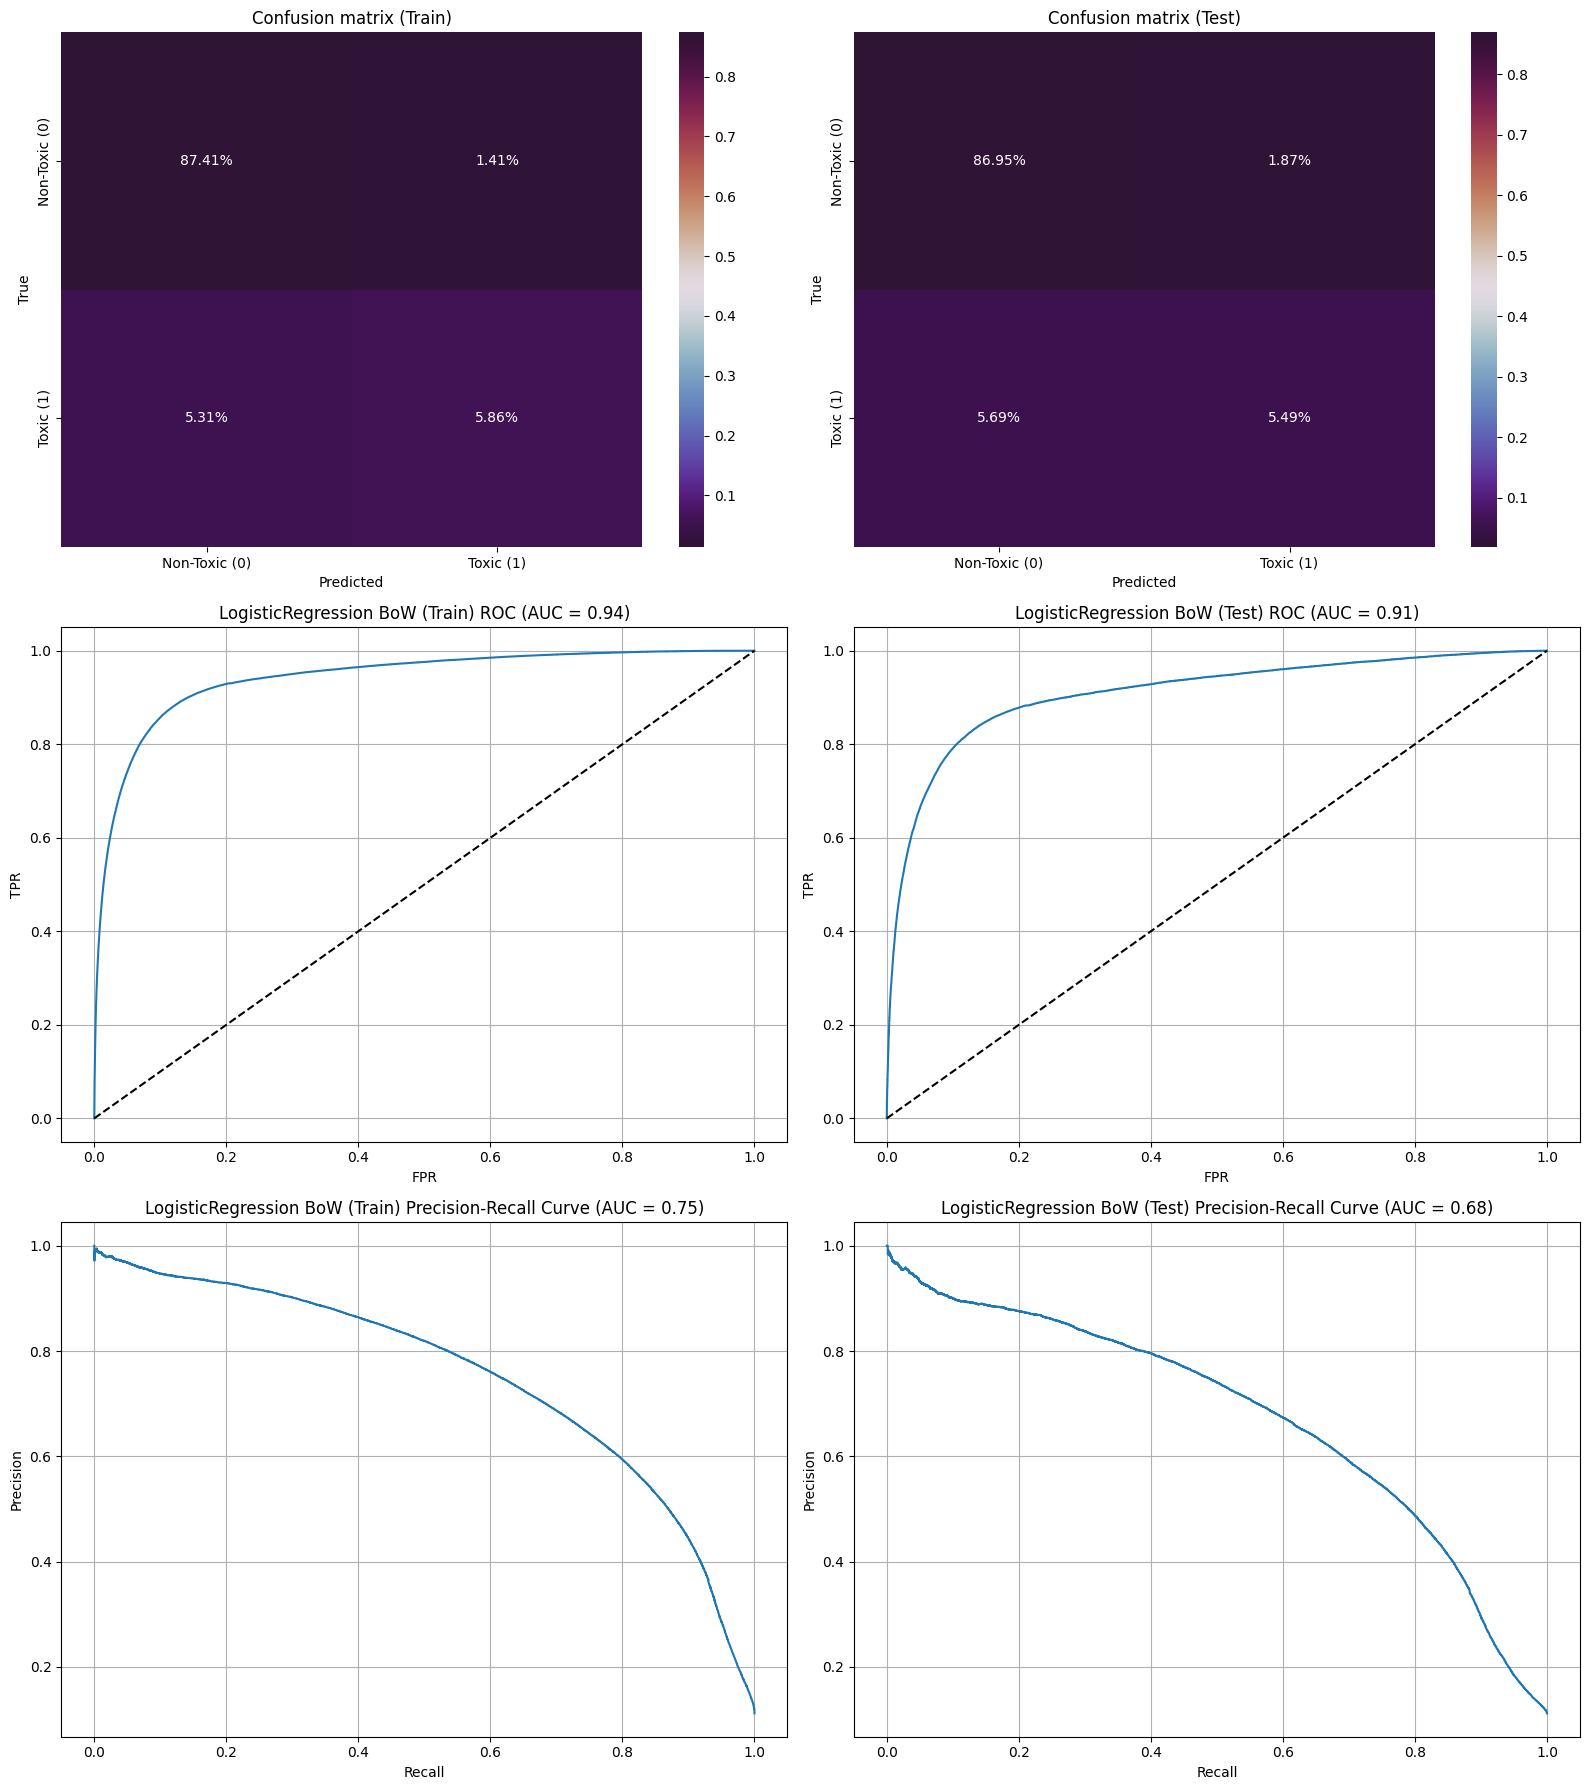

In [13]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

#### SVM

In [14]:
(
    y_linear_svc_bow_pred_train,
    y_linear_svc_bow_pred_test,
    y_linear_svc_bow_pred_proba_train,
    y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(dual=False),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

SVM BoW

Precision		Recall			F1

Train: 0.85		Train: 0.58		Train: 0.69
Test: 0.72		Test: 0.49		Test: 0.58


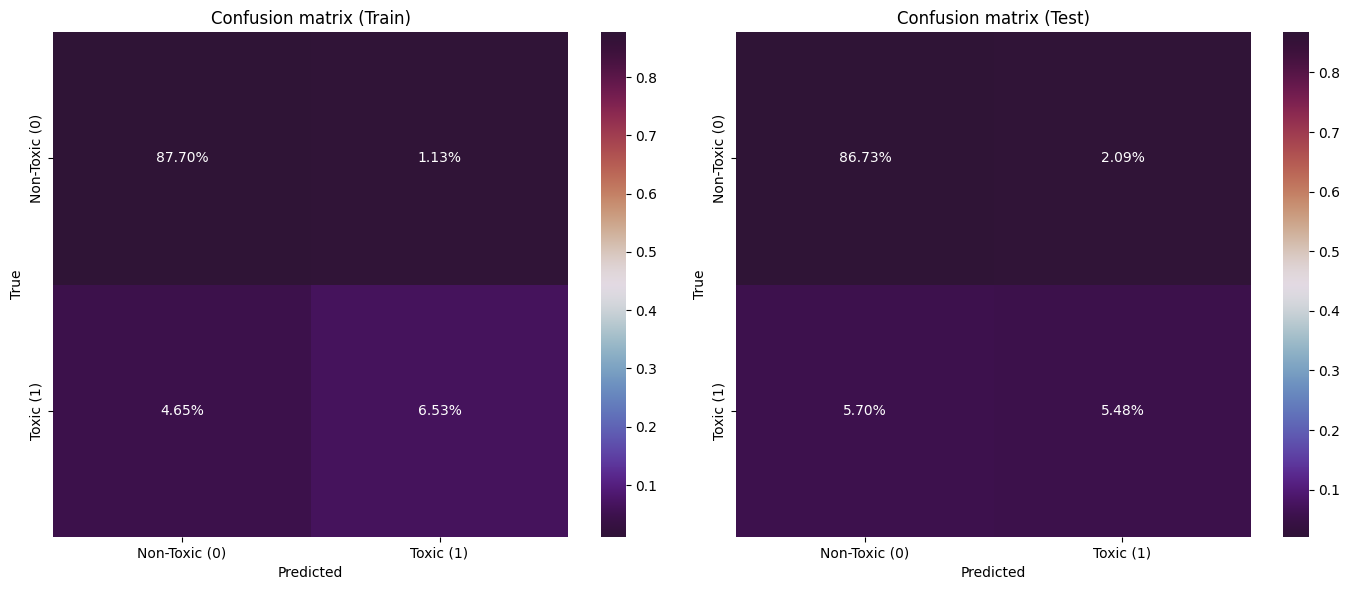

In [15]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

#### Наивный Байес

In [16]:
(
    y_nb_bow_pred_train,
    y_nb_bow_pred_test,
    y_nb_bow_pred_proba_train,
    y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

MultinomialNB BoW

Precision		Recall			F1

Train: 0.50		Train: 0.63		Train: 0.56
Test: 0.49		Test: 0.59		Test: 0.54


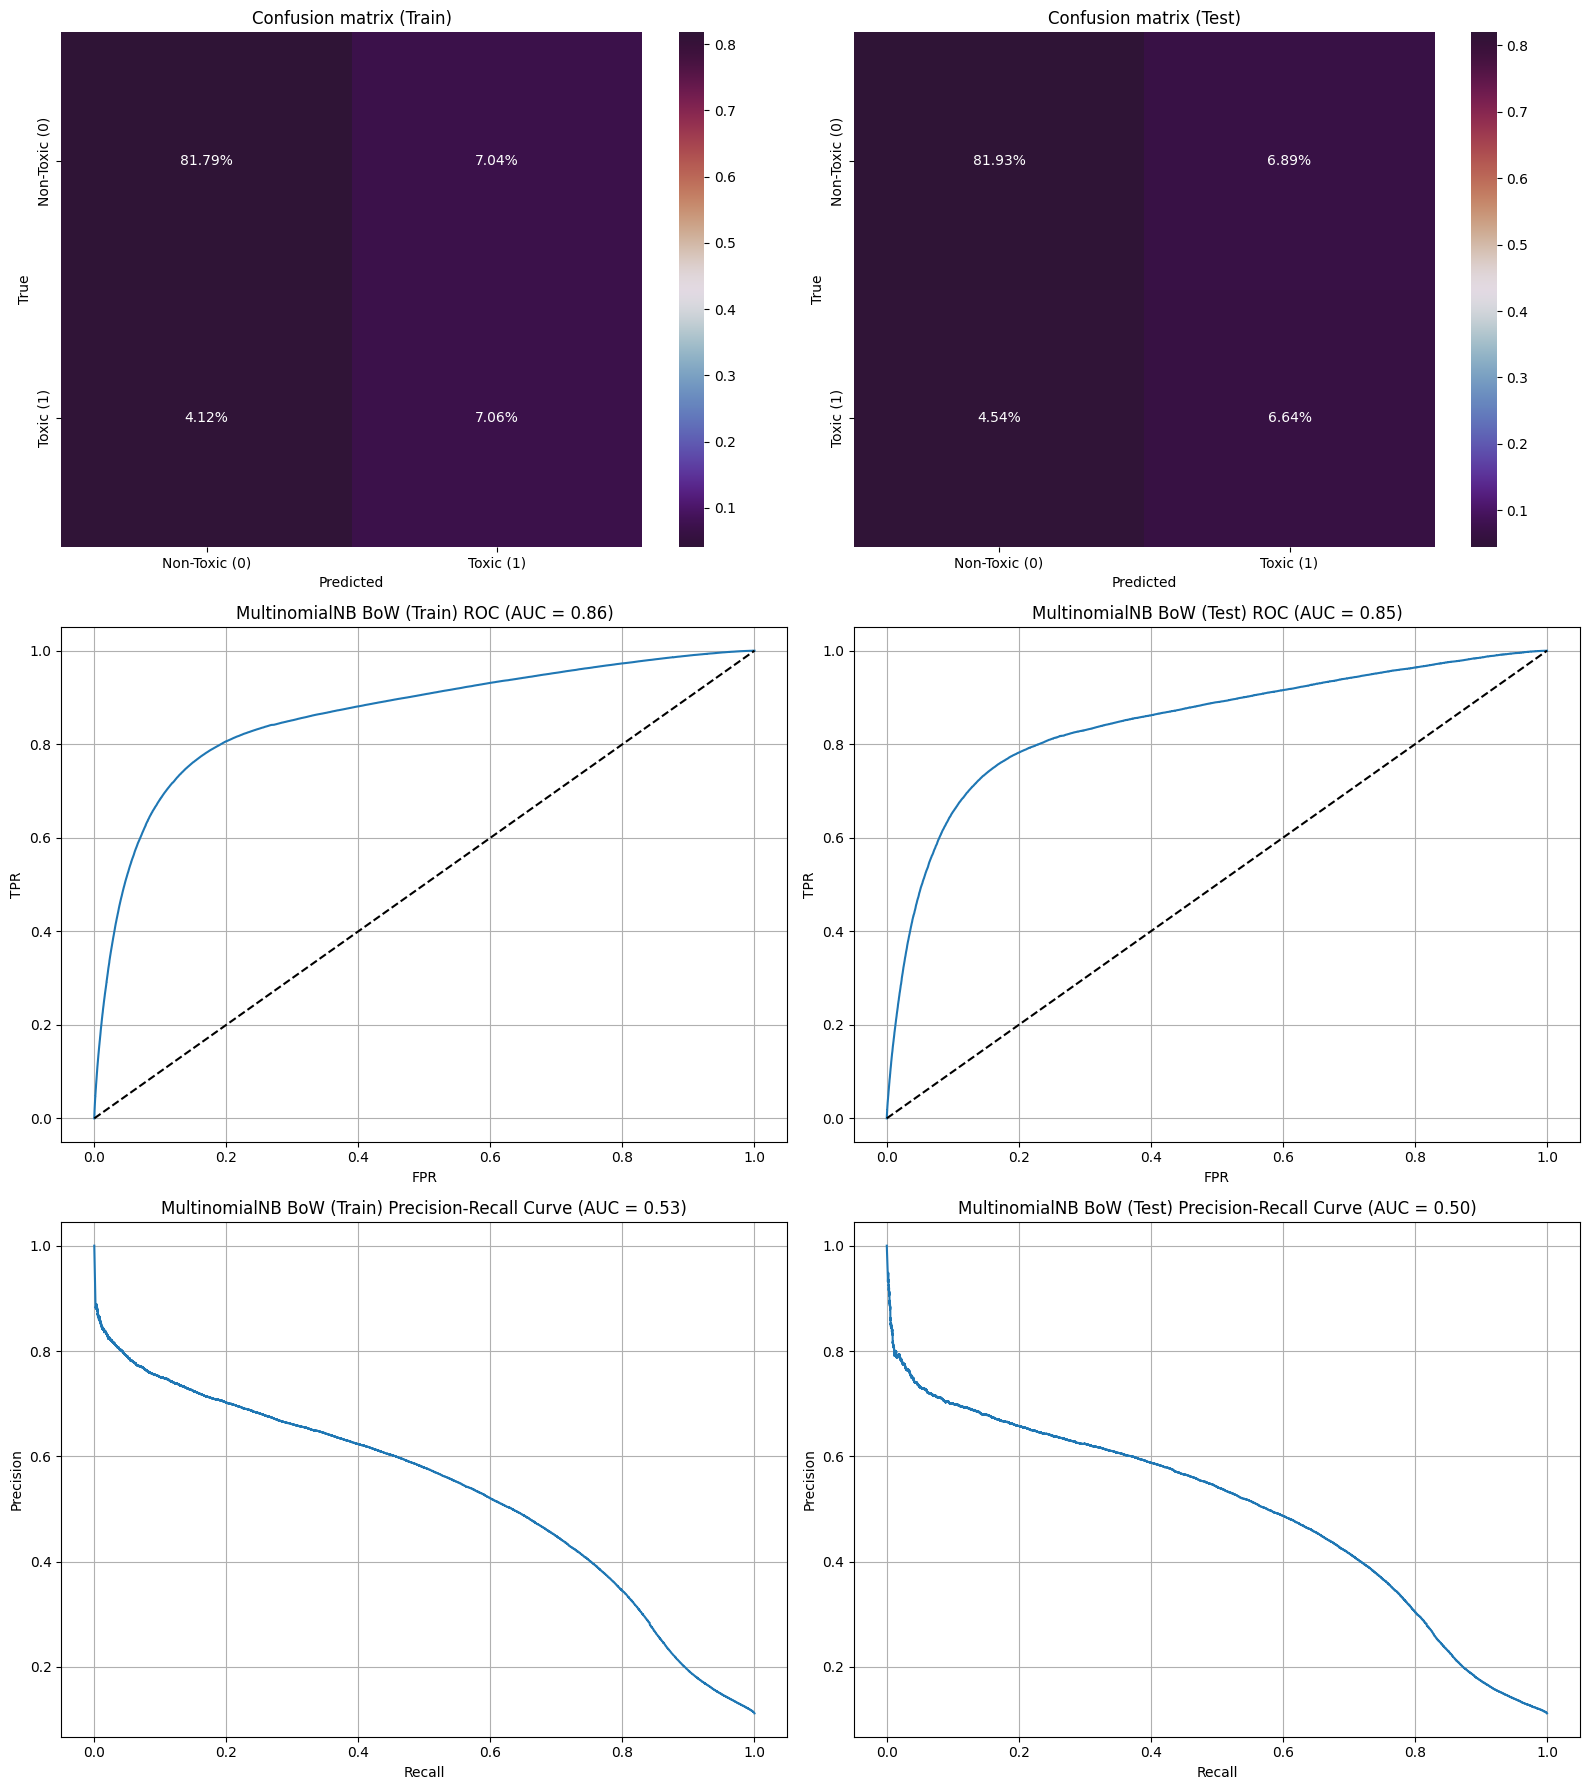

In [17]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

### Обучение с TF-IDF

In [18]:
X_train_tfidf, X_test_tfidf = get_tfidf(X_train, X_test)

#### Логистическая регрессия

In [19]:
(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.79		Train: 0.49		Train: 0.61
Test: 0.78		Test: 0.49		Test: 0.60


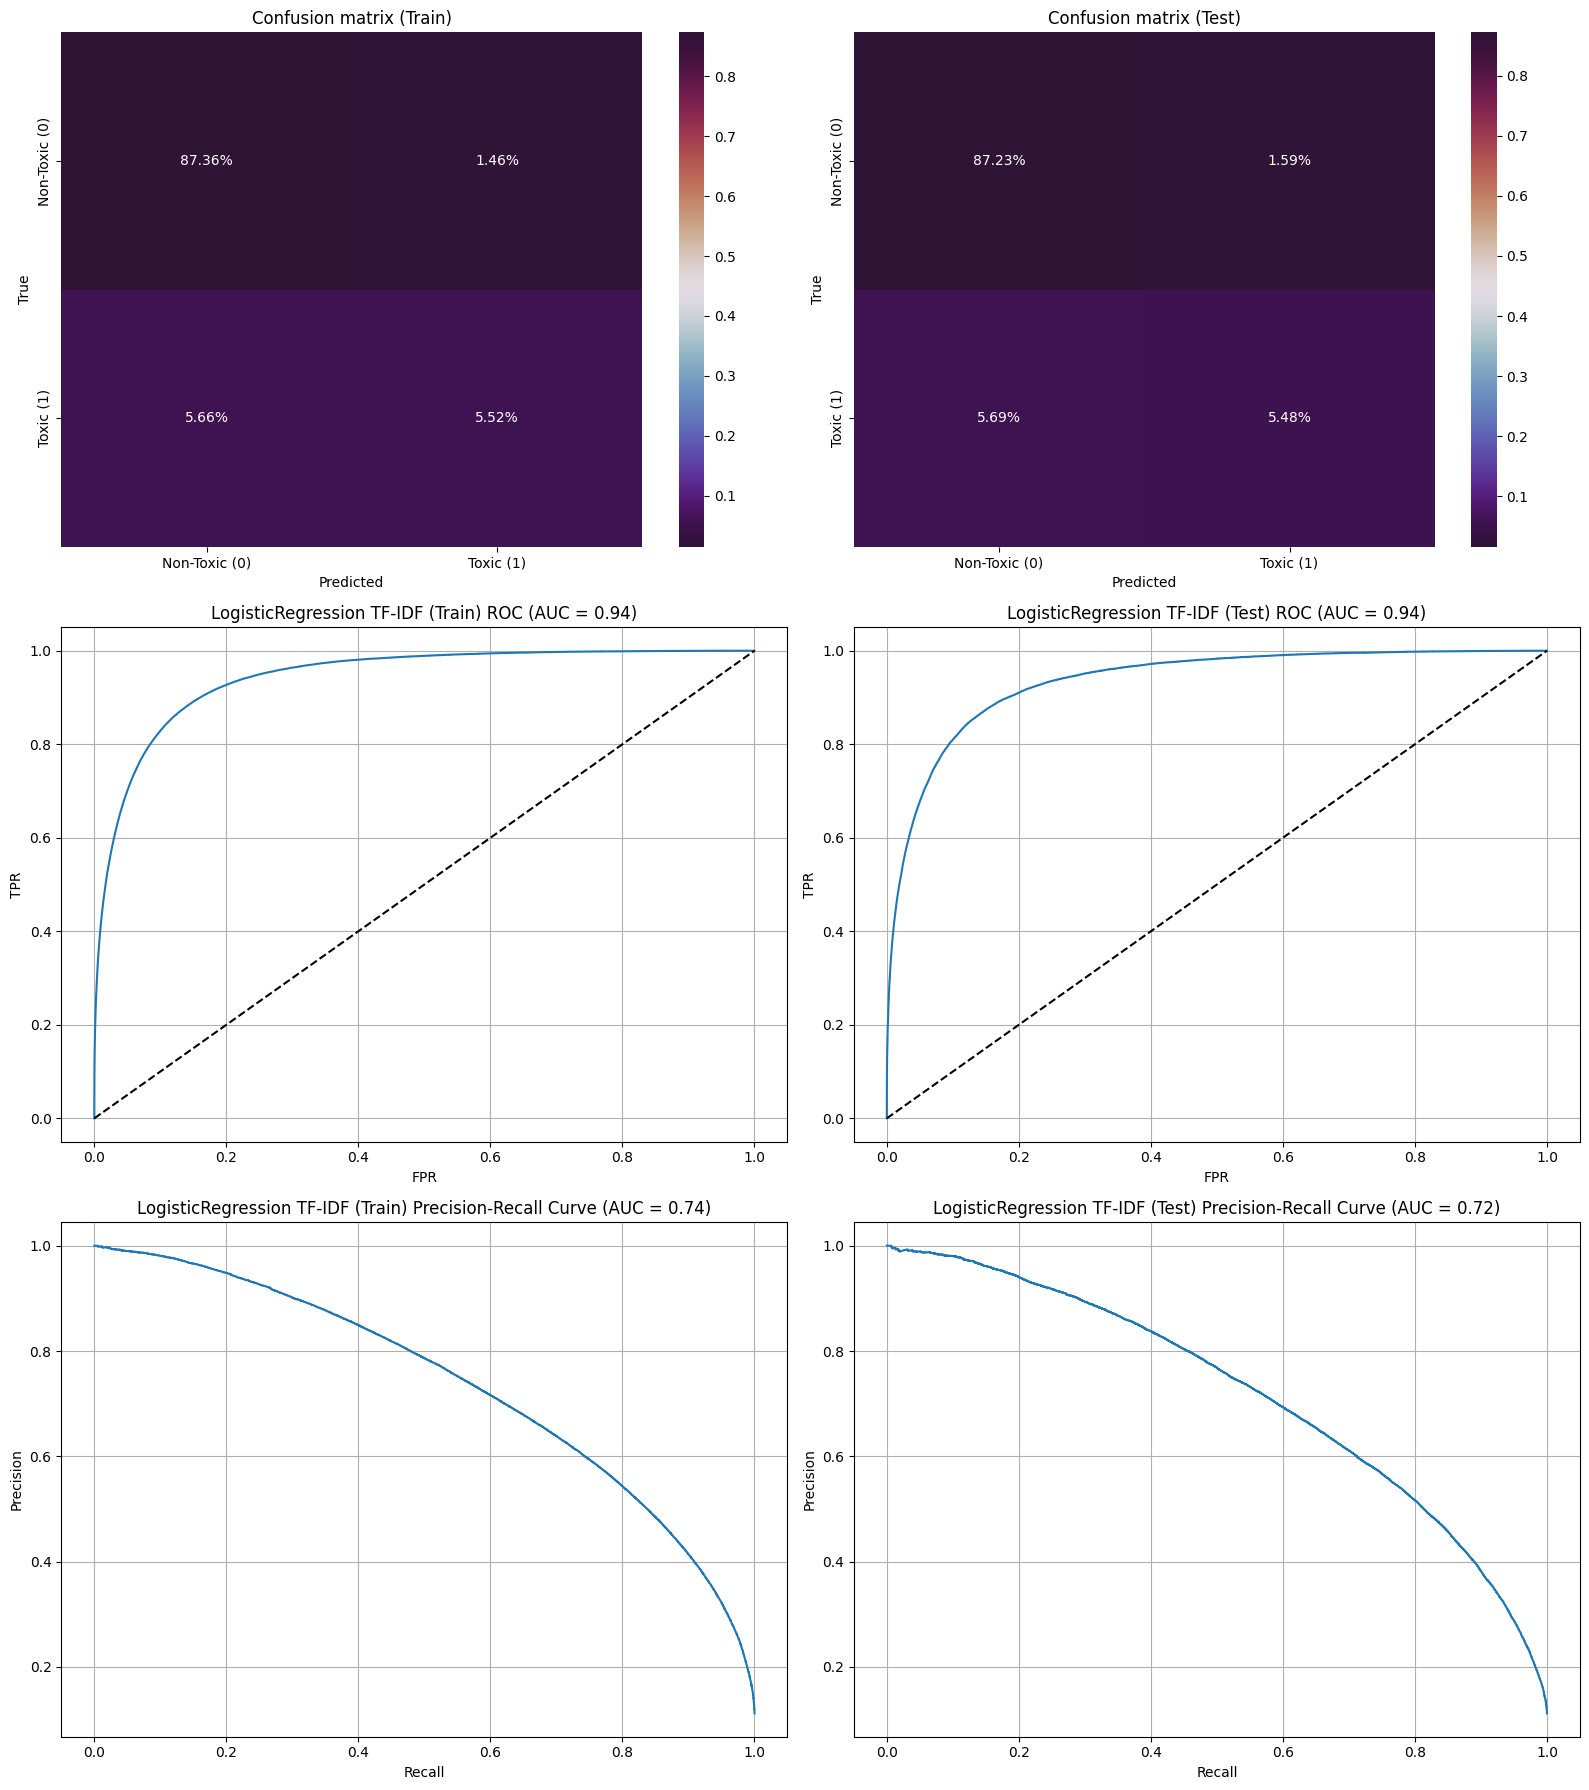

In [20]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

#### SVM

In [21]:
(
    y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(dual=False),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

SVM TF-IDF

Precision		Recall			F1

Train: 0.83		Train: 0.55		Train: 0.66
Test: 0.78		Test: 0.50		Test: 0.61


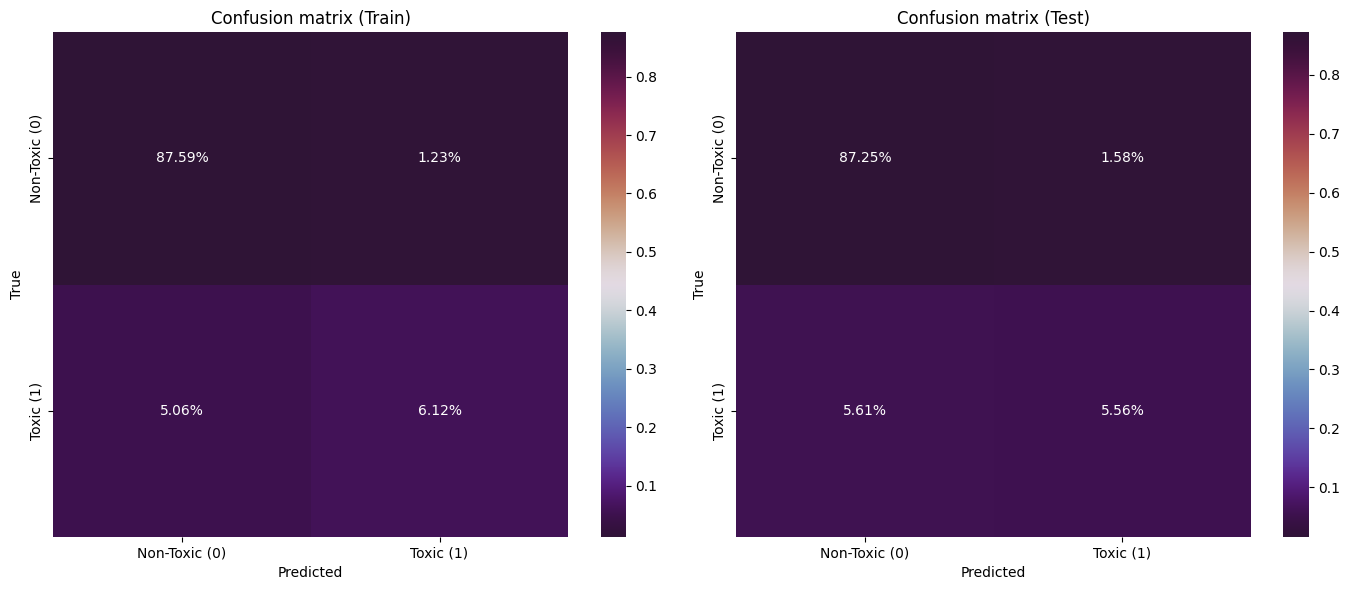

In [22]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

#### Наивный Байес

In [23]:
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.94		Train: 0.07		Train: 0.13
Test: 0.94		Test: 0.06		Test: 0.11


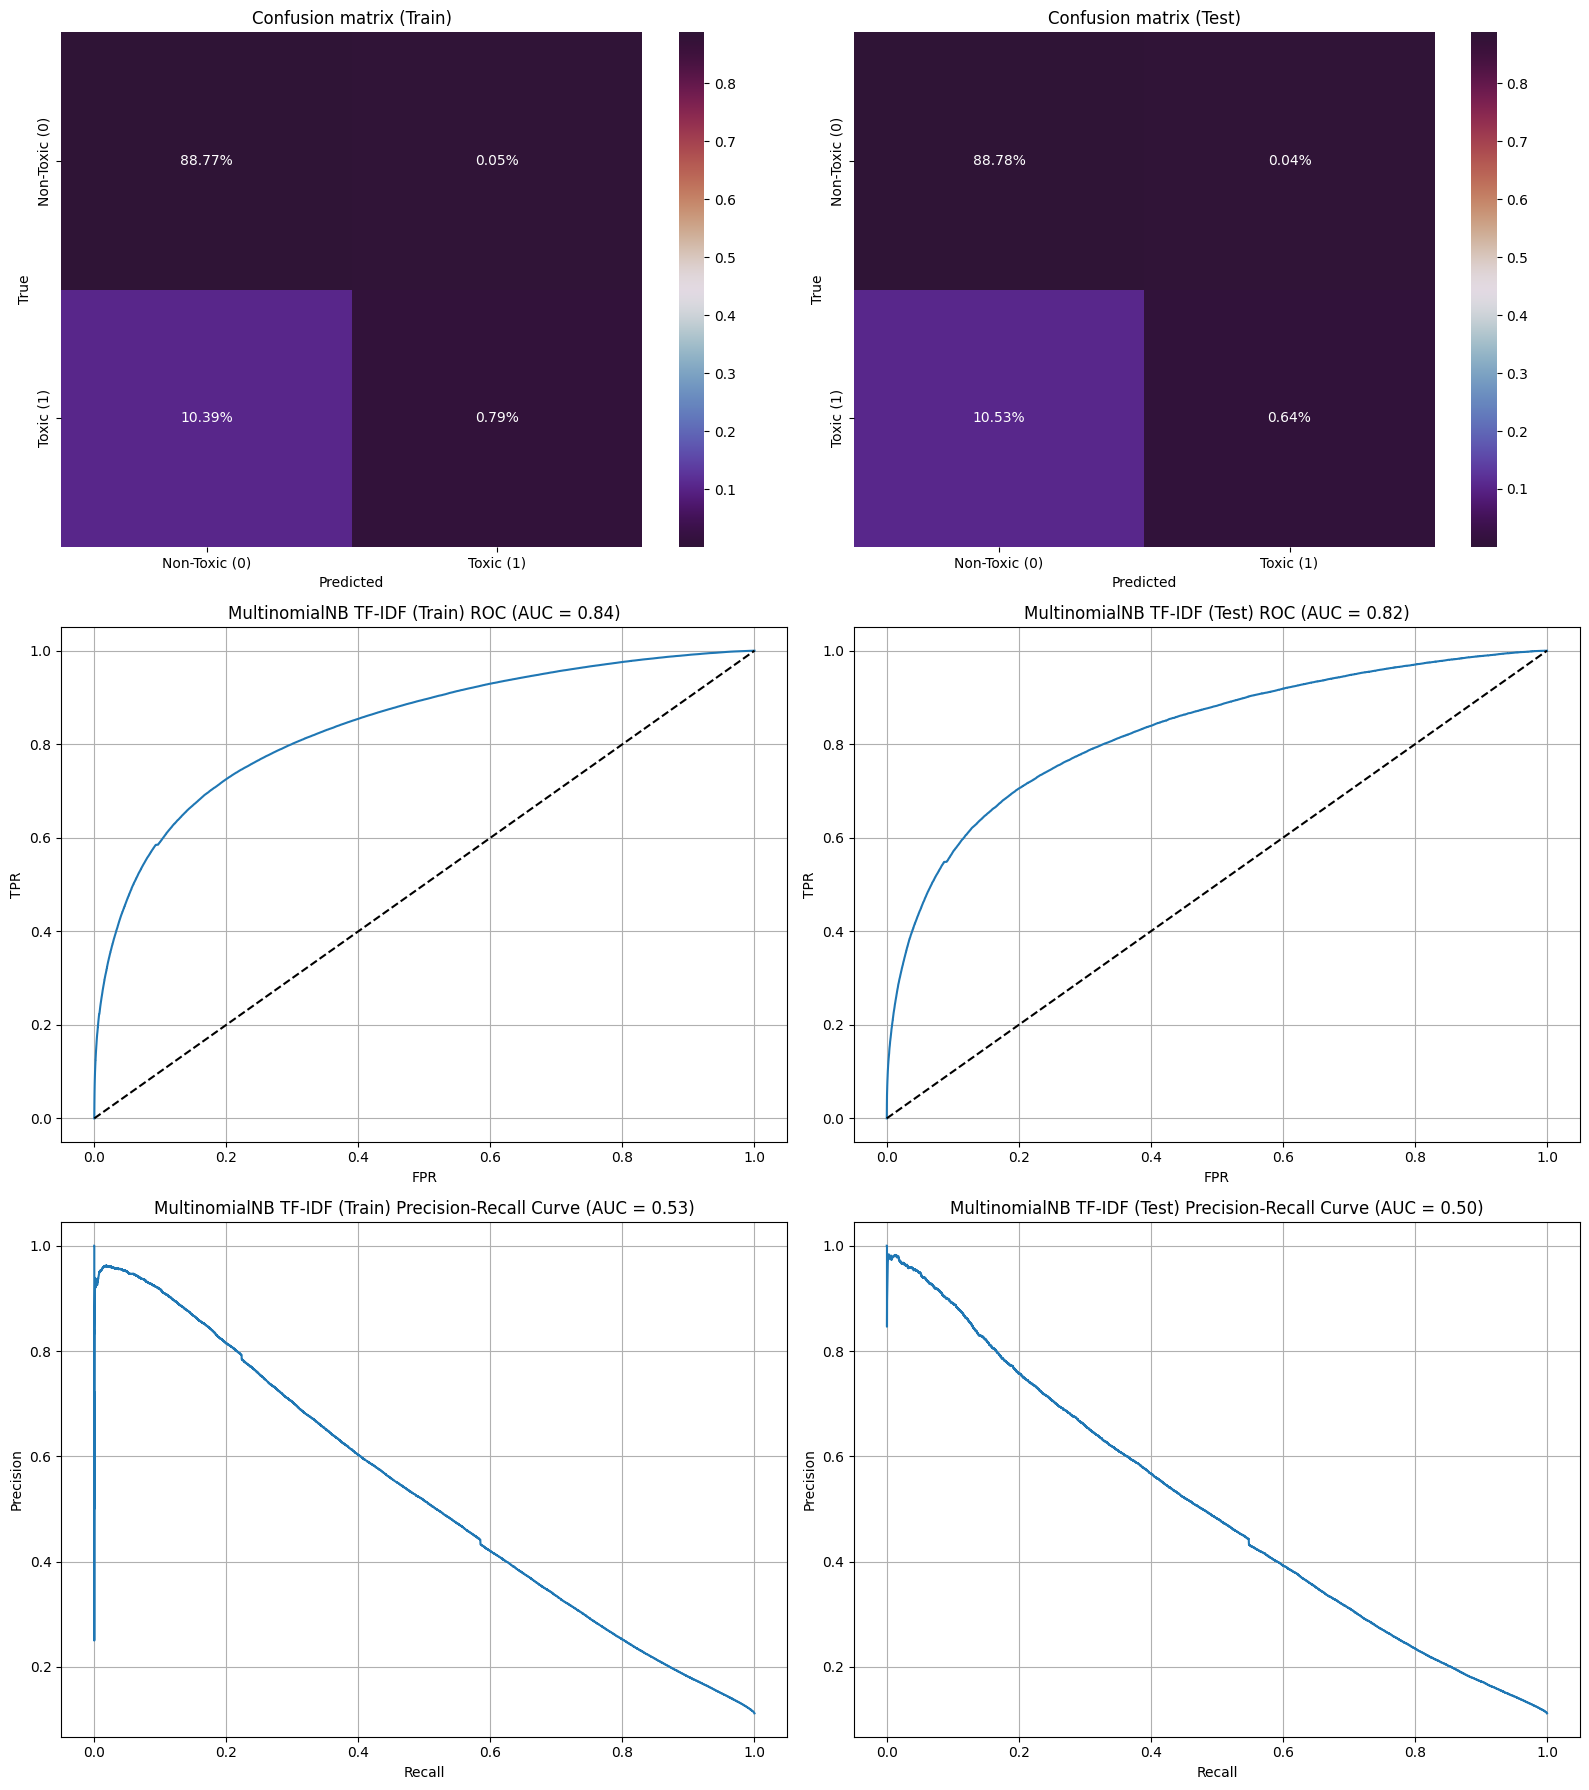

In [24]:
show_metrics(
    y_train=y_train,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

# Multi-Label  классификация

## Обучение моделей

In [25]:
labels = df[['toxicity_b', 'severe_toxicity_b', 'obscene_b', 'identity_attack_b', 'insult_b', 'threat_b', 'sexual_explicit_b']]

X = df['ctws']
y = labels

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

def train_and_predict_toxicity_multilabel(model, X_train, X_test, y_train):
    ovr = OneVsRestClassifier(model, n_jobs=-1)
    ovr.fit(X_train, y_train)

    y_pred_train = ovr.predict(X_train)
    y_pred_test = ovr.predict(X_test)

    return y_pred_train, y_pred_test

def show_classification_report(y_train, y_test, y_pred_train, y_pred_test, target_names, title):
    report_train = classification_report(y_train, y_pred_train, target_names=target_names, zero_division=0, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, target_names=target_names, zero_division=0, output_dict=True)

    report_train_df = pd.DataFrame(report_train).transpose()
    report_test_df = pd.DataFrame(report_test).transpose()

    print(f"{title}\n")

    print("METRICS PER CLASS\n")
    print("Train:")
    display(report_train_df.iloc[:-4, :])
    print("\nTest:")
    display(report_test_df.iloc[:-4, :])

    print("\nOVERALL METRICS\n")
    print("Train:")
    display(report_train_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']))
    print("\nTest:")
    display(report_test_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']))

    def show_heatmap(report_df, ax, model_name, sample_name):
        heatmap_df = report_df.iloc[:-4, :]
        
        sns.heatmap(heatmap_df.iloc[:, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=True, linewidths=0.5, ax=ax)
        ax.set_title(f"{model_name} Classification Report Heatmap ({sample_name})", fontsize=16)
        ax.set_ylabel("Classes", fontsize=12)
        ax.set_xlabel("Metrics", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    show_heatmap(report_train_df, axes[0], title, "Train")
    show_heatmap(report_test_df, axes[1], title, "Test")

    plt.tight_layout()
    plt.show()

### Обучение с мешком слов

In [28]:
X_train_bow, X_test_bow = get_bows(X_train, X_test)

#### Логистическая регрессия

In [29]:
y_log_reg_bow_pred_train, y_log_reg_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

Multi-Label LogisticRegression BoW

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.80,0.53,0.64,160874.00
severe_toxicity_b,0.00,0.00,0.00,52.00
obscene_b,0.71,0.45,0.55,11072.00
identity_attack_b,0.62,0.24,0.34,19880.00
insult_b,0.81,0.55,0.66,120949.00
threat_b,0.49,0.10,0.17,6209.00
sexual_explicit_b,0.66,0.34,0.45,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.75,0.48,0.59,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.60,0.37,0.46,2792.00
identity_attack_b,0.49,0.19,0.27,5101.00
insult_b,0.75,0.51,0.61,30109.00
threat_b,0.29,0.07,0.11,1533.00
sexual_explicit_b,0.54,0.27,0.36,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.79,0.50,0.62
macro avg,0.58,0.32,0.40
weighted avg,0.78,0.50,0.61
samples avg,0.06,0.06,0.06



Test:


,precision,recall,f1-score
micro avg,0.73,0.46,0.56
macro avg,0.49,0.27,0.34
weighted avg,0.71,0.46,0.56
samples avg,0.05,0.05,0.05


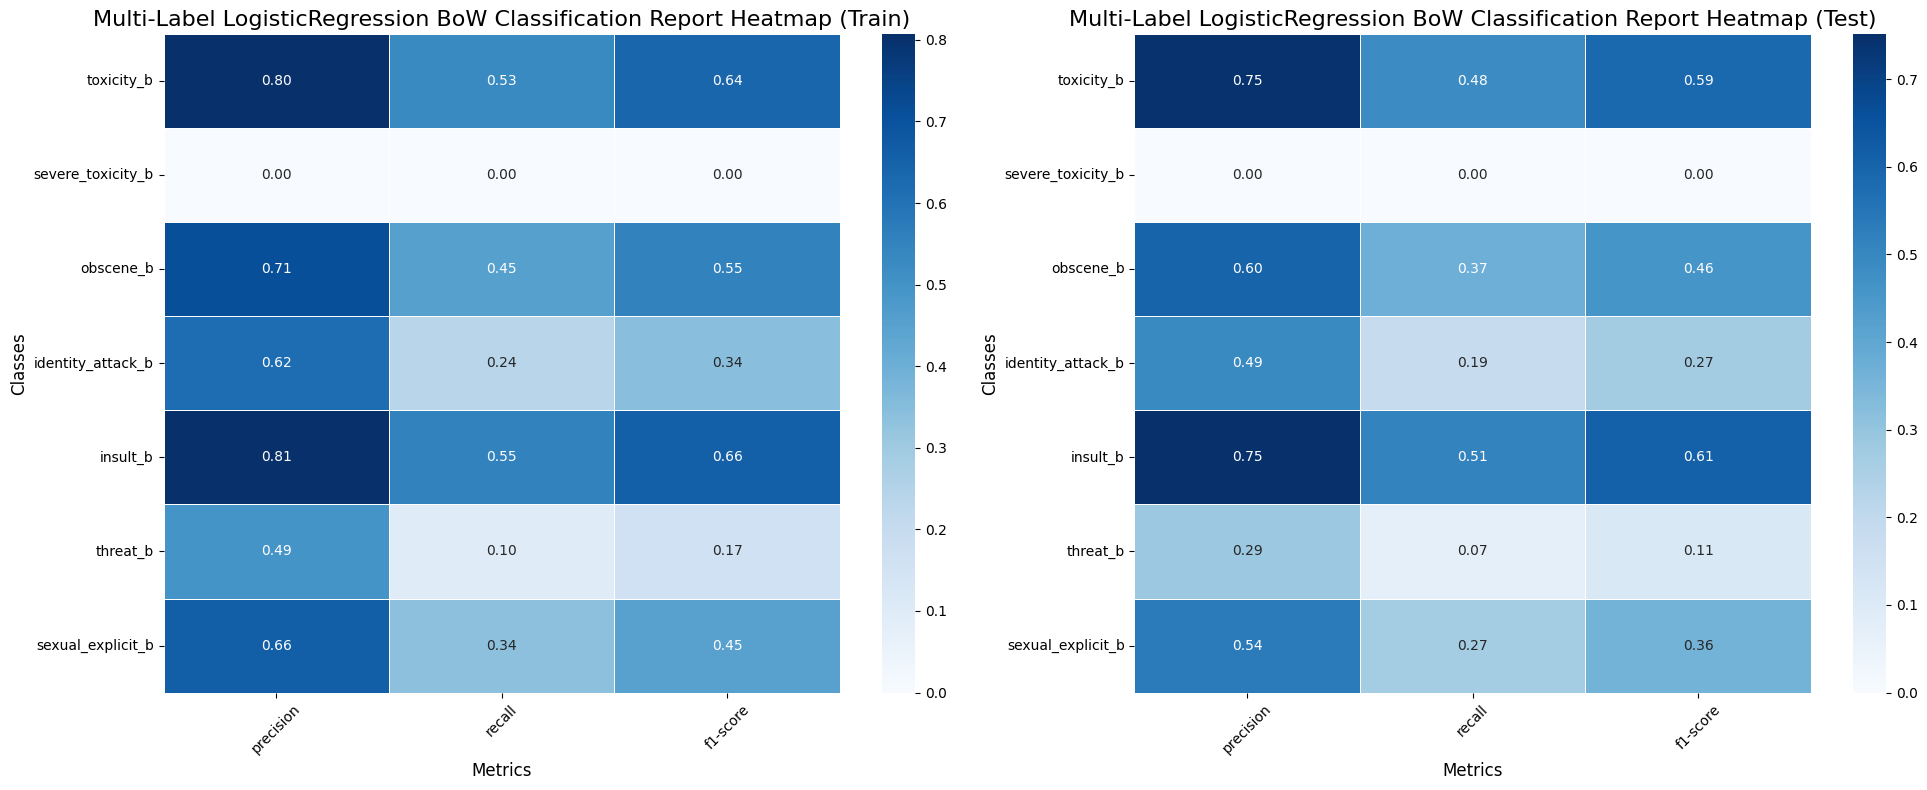

In [30]:

show_classification_report(
    y_train,
    y_test,
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_test,
    y.columns,
    'Multi-Label LogisticRegression BoW'
)


#### SVM

In [34]:
y_svm_bow_pred_train, y_svm_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=LinearSVC(dual=False),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

Multi-Label SVM BoW

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.85,0.58,0.69,160874.00
severe_toxicity_b,1.00,0.85,0.92,52.00
obscene_b,0.91,0.76,0.83,11072.00
identity_attack_b,0.86,0.42,0.57,19880.00
insult_b,0.86,0.62,0.72,120949.00
threat_b,0.91,0.31,0.47,6209.00
sexual_explicit_b,0.94,0.73,0.82,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.72,0.48,0.58,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.55,0.42,0.48,2792.00
identity_attack_b,0.47,0.20,0.28,5101.00
insult_b,0.73,0.51,0.60,30109.00
threat_b,0.26,0.08,0.13,1533.00
sexual_explicit_b,0.44,0.32,0.37,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.86,0.59,0.70
macro avg,0.90,0.61,0.72
weighted avg,0.86,0.59,0.70
samples avg,0.07,0.07,0.07



Test:


,precision,recall,f1-score
micro avg,0.70,0.46,0.56
macro avg,0.45,0.29,0.35
weighted avg,0.69,0.46,0.55
samples avg,0.06,0.05,0.05


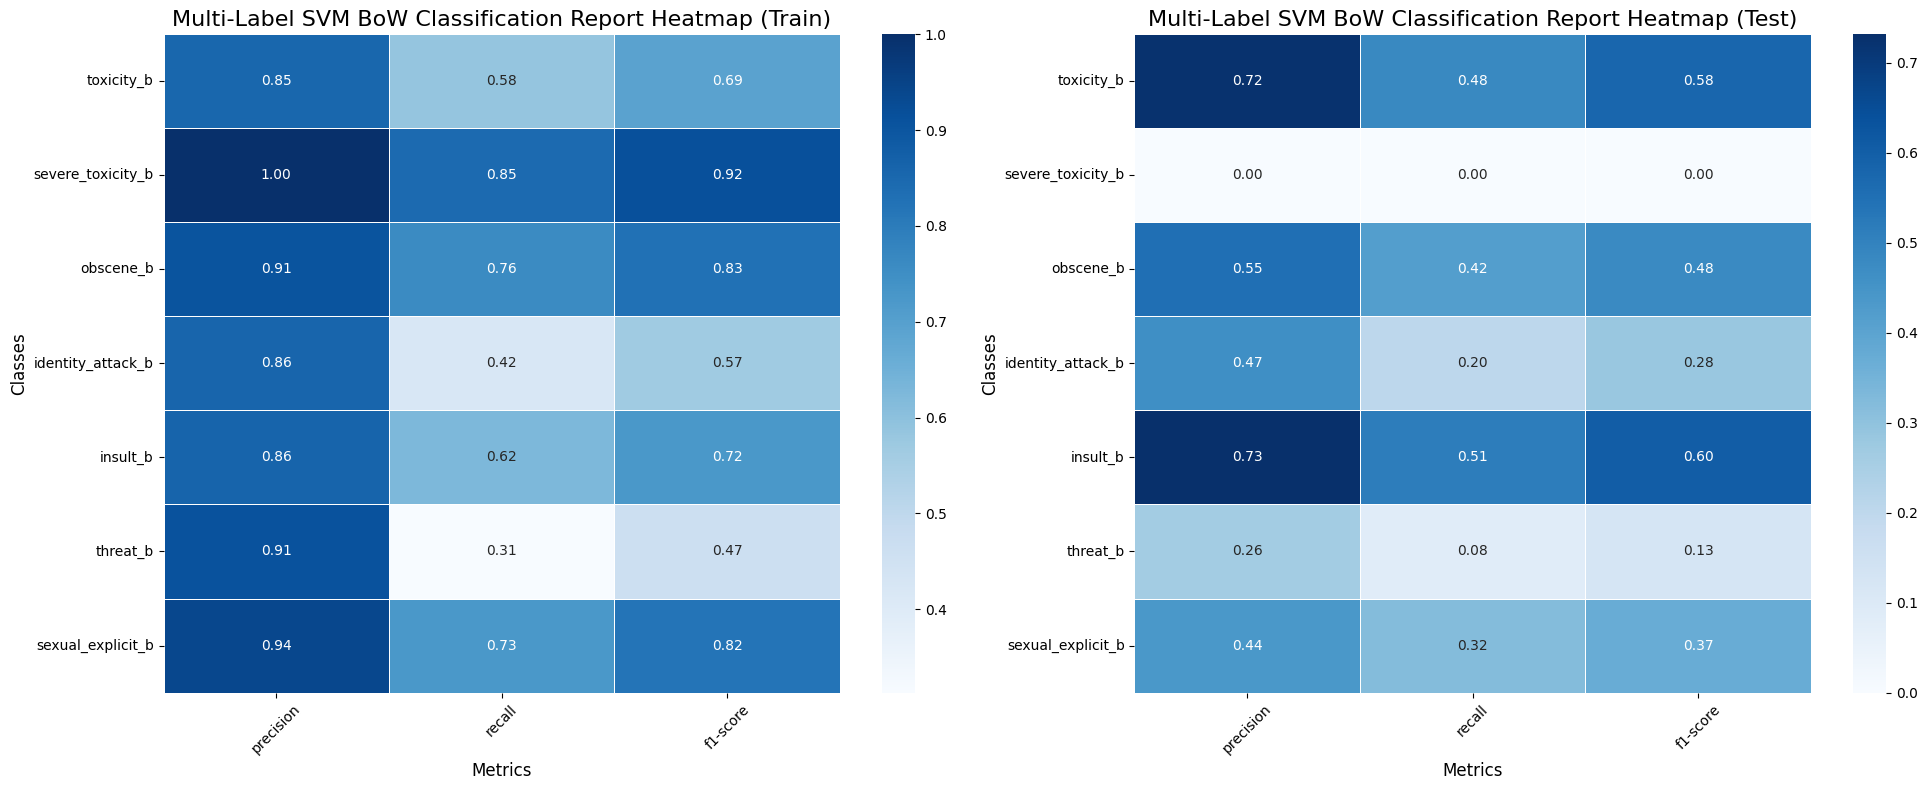

In [35]:
show_classification_report(
    y_train,
    y_test,
    y_svm_bow_pred_train,
    y_svm_bow_pred_test,
    y.columns,
    'Multi-Label SVM BoW'
)

#### Наивный Байес

In [ ]:
y_nb_bow_pred_train, y_nb_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(),
    X_train=X_train_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

Multi-Label MultinomialNB BoW

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.50,0.63,0.56,160874.00
severe_toxicity_b,0.01,0.02,0.01,52.00
obscene_b,0.26,0.12,0.17,11072.00
identity_attack_b,0.30,0.43,0.35,19880.00
insult_b,0.49,0.61,0.54,120949.00
threat_b,0.07,0.02,0.03,6209.00
sexual_explicit_b,0.24,0.12,0.16,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.49,0.59,0.54,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.30,0.07,0.12,2792.00
identity_attack_b,0.30,0.36,0.33,5101.00
insult_b,0.48,0.57,0.52,30109.00
threat_b,0.05,0.01,0.01,1533.00
sexual_explicit_b,0.26,0.07,0.11,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.48,0.57,0.52
macro avg,0.27,0.28,0.26
weighted avg,0.46,0.57,0.51
samples avg,0.07,0.07,0.06



Test:


,precision,recall,f1-score
micro avg,0.47,0.53,0.50
macro avg,0.27,0.24,0.23
weighted avg,0.46,0.53,0.49
samples avg,0.06,0.06,0.06


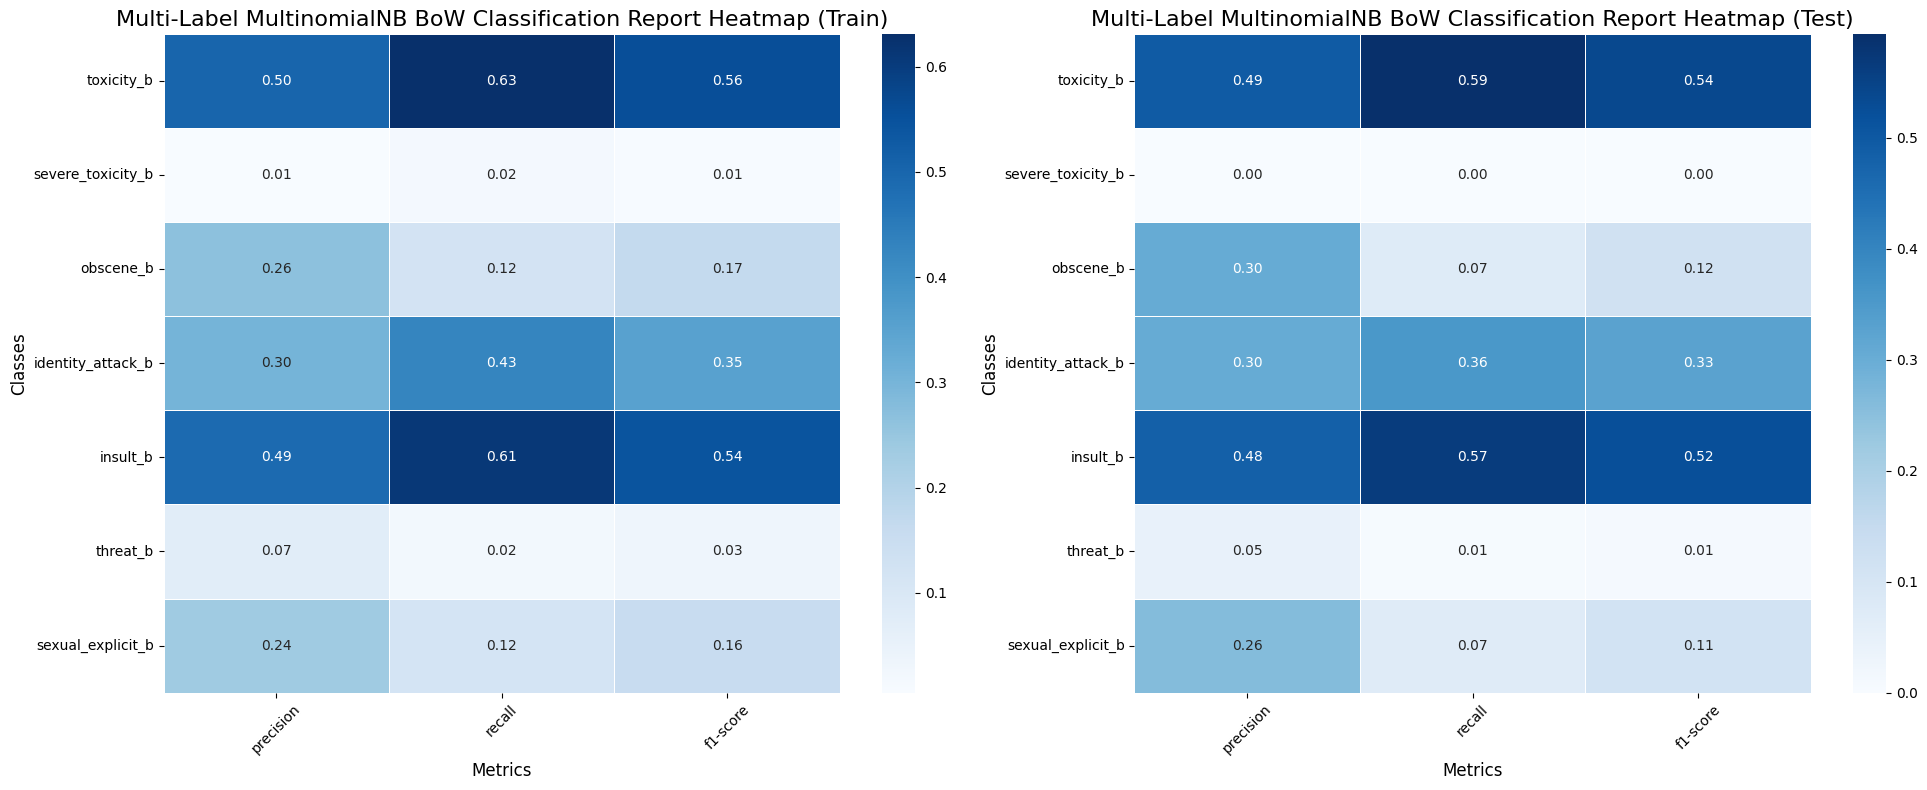

In [37]:
show_classification_report(
    y_train,
    y_test,
    y_nb_bow_pred_train,
    y_nb_bow_pred_test,
    y.columns,
    'Multi-Label MultinomialNB BoW'
)

### Обучение с TF-IDF

In [38]:
X_train_tfidf, X_test_tfidf = get_tfidf(X_train, X_test)

#### Логистическая регрессия

In [39]:
y_log_reg_tfidf_pred_train, y_log_reg_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

Multi-Label LogisticRegression TF-IDF

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.79,0.49,0.61,160874.00
severe_toxicity_b,0.00,0.00,0.00,52.00
obscene_b,0.67,0.27,0.39,11072.00
identity_attack_b,0.55,0.22,0.32,19880.00
insult_b,0.80,0.50,0.61,120949.00
threat_b,0.44,0.08,0.14,6209.00
sexual_explicit_b,0.59,0.22,0.32,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.78,0.49,0.60,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.68,0.26,0.38,2792.00
identity_attack_b,0.56,0.22,0.32,5101.00
insult_b,0.79,0.49,0.61,30109.00
threat_b,0.40,0.07,0.12,1533.00
sexual_explicit_b,0.58,0.21,0.31,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.78,0.46,0.58
macro avg,0.55,0.25,0.34
weighted avg,0.76,0.46,0.57
samples avg,0.06,0.05,0.05



Test:


,precision,recall,f1-score
micro avg,0.77,0.45,0.57
macro avg,0.54,0.25,0.33
weighted avg,0.76,0.45,0.56
samples avg,0.06,0.05,0.05


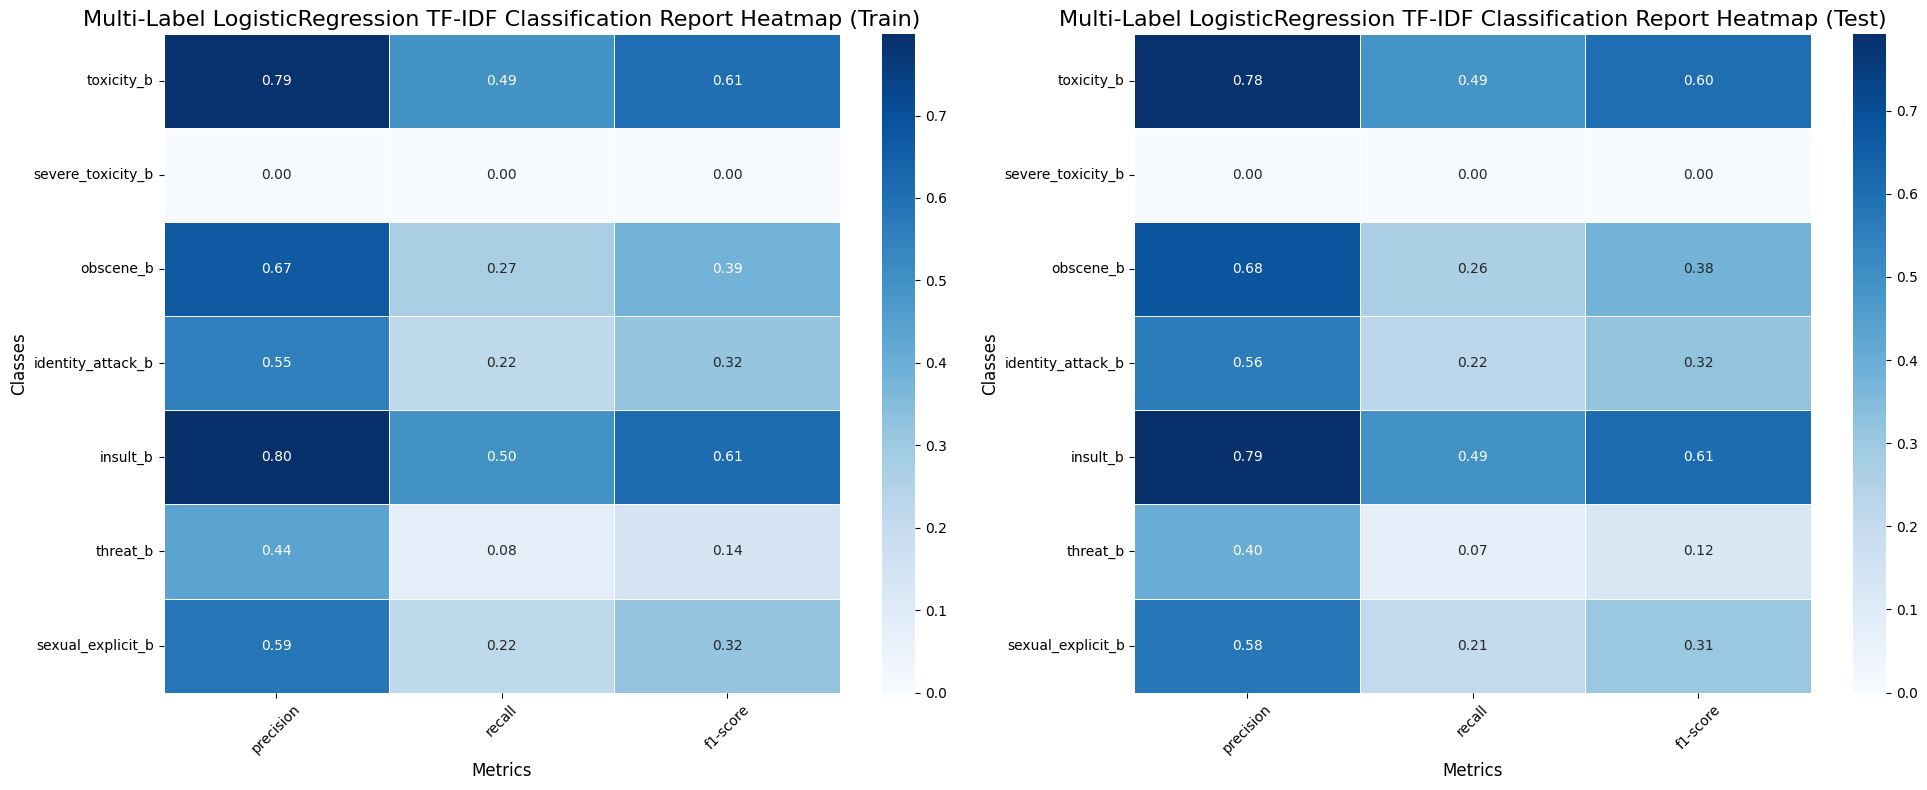

In [40]:
show_classification_report(
    y_train,
    y_test,
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_test,
    y.columns,
    'Multi-Label LogisticRegression TF-IDF'
)

#### SVM

In [41]:
y_svm_tfidf_pred_train, y_svm_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=LinearSVC(dual=False),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

Multi-Label SVM TF-IDF

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.83,0.55,0.66,160874.00
severe_toxicity_b,1.00,0.21,0.35,52.00
obscene_b,0.85,0.47,0.60,11072.00
identity_attack_b,0.75,0.30,0.43,19880.00
insult_b,0.85,0.56,0.68,120949.00
threat_b,0.82,0.12,0.21,6209.00
sexual_explicit_b,0.86,0.43,0.57,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.78,0.50,0.61,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.71,0.32,0.44,2792.00
identity_attack_b,0.61,0.22,0.32,5101.00
insult_b,0.80,0.51,0.62,30109.00
threat_b,0.65,0.07,0.12,1533.00
sexual_explicit_b,0.64,0.25,0.36,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.84,0.52,0.64
macro avg,0.85,0.38,0.50
weighted avg,0.83,0.52,0.64
samples avg,0.06,0.06,0.06



Test:


,precision,recall,f1-score
micro avg,0.78,0.46,0.58
macro avg,0.60,0.26,0.35
weighted avg,0.77,0.46,0.57
samples avg,0.06,0.05,0.05


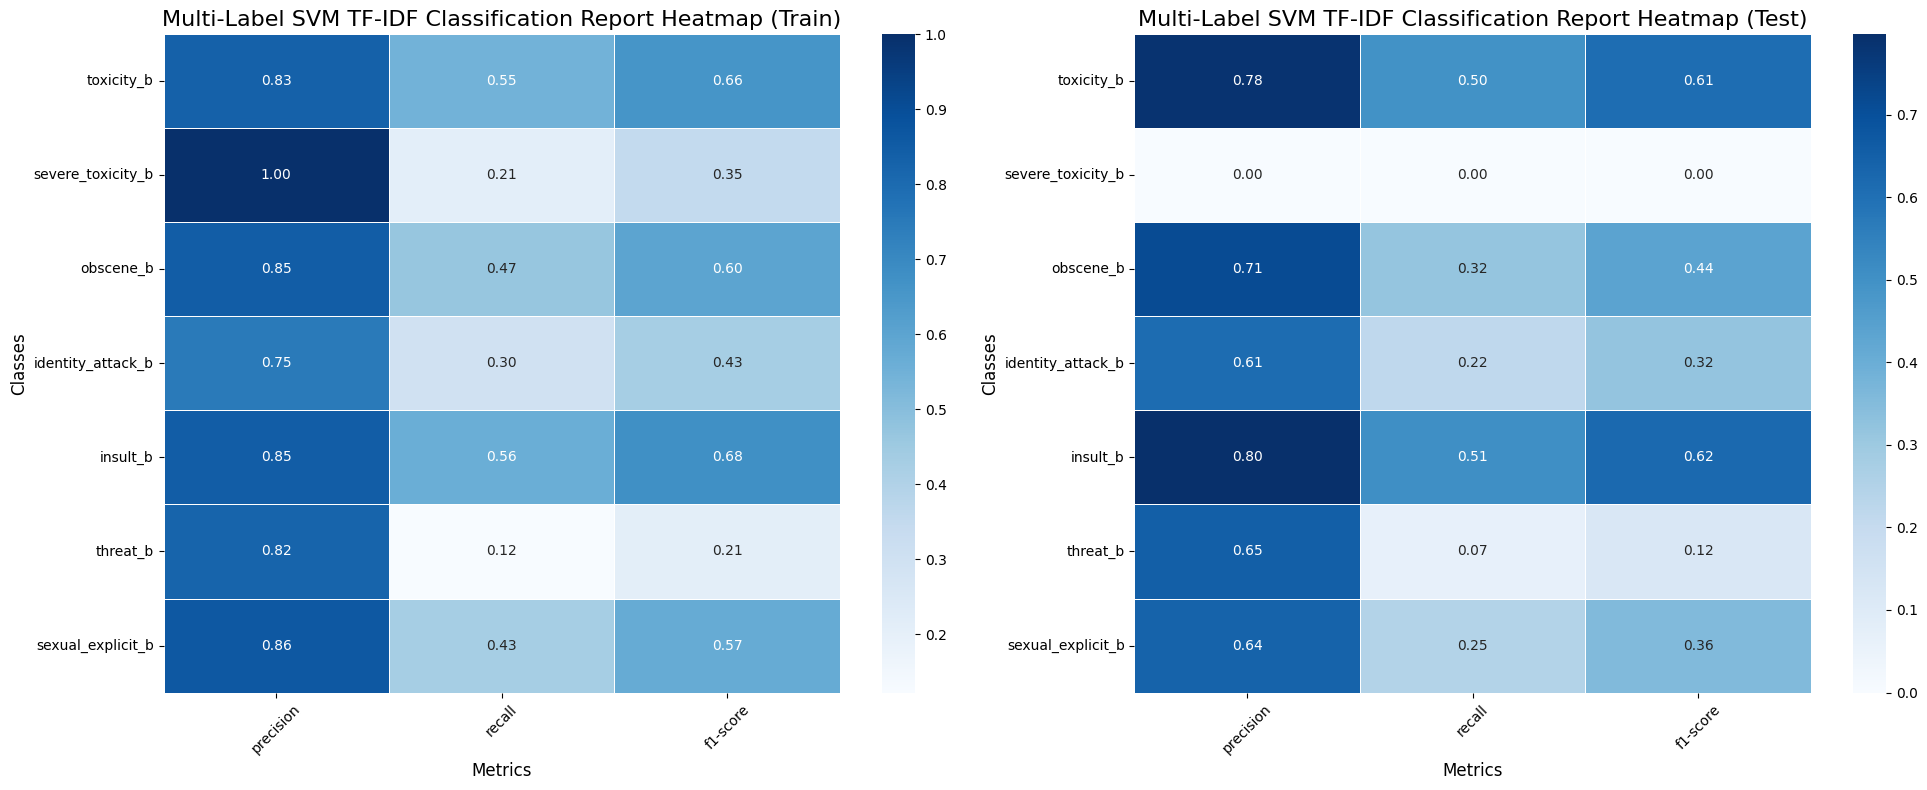

In [42]:
show_classification_report(
    y_train,
    y_test,
    y_svm_tfidf_pred_train,
    y_svm_tfidf_pred_test,
    y.columns,
    'Multi-Label SVM TF-IDF'
)

#### Наивный Байес

In [43]:
y_nb_tfidf_pred_train, y_nb_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(),
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

Multi-Label MultinomialNB TF-IDF

METRICS PER CLASS

Train:


,precision,recall,f1-score,support
toxicity_b,0.94,0.07,0.13,160874.00
severe_toxicity_b,0.00,0.00,0.00,52.00
obscene_b,0.26,0.00,0.01,11072.00
identity_attack_b,0.18,0.00,0.00,19880.00
insult_b,0.92,0.05,0.10,120949.00
threat_b,0.00,0.00,0.00,6209.00
sexual_explicit_b,0.04,0.00,0.00,6292.00



Test:


,precision,recall,f1-score,support
toxicity_b,0.93,0.06,0.11,40242.00
severe_toxicity_b,0.00,0.00,0.00,23.00
obscene_b,0.73,0.00,0.01,2792.00
identity_attack_b,0.53,0.00,0.00,5101.00
insult_b,0.93,0.04,0.08,30109.00
threat_b,0.00,0.00,0.00,1533.00
sexual_explicit_b,0.00,0.00,0.00,1646.00



OVERALL METRICS

Train:


,precision,recall,f1-score
micro avg,0.91,0.05,0.10
macro avg,0.33,0.02,0.03
weighted avg,0.83,0.05,0.10
samples avg,0.01,0.01,0.01



Test:


,precision,recall,f1-score
micro avg,0.93,0.04,0.08
macro avg,0.45,0.01,0.03
weighted avg,0.86,0.04,0.08
samples avg,0.01,0.00,0.01


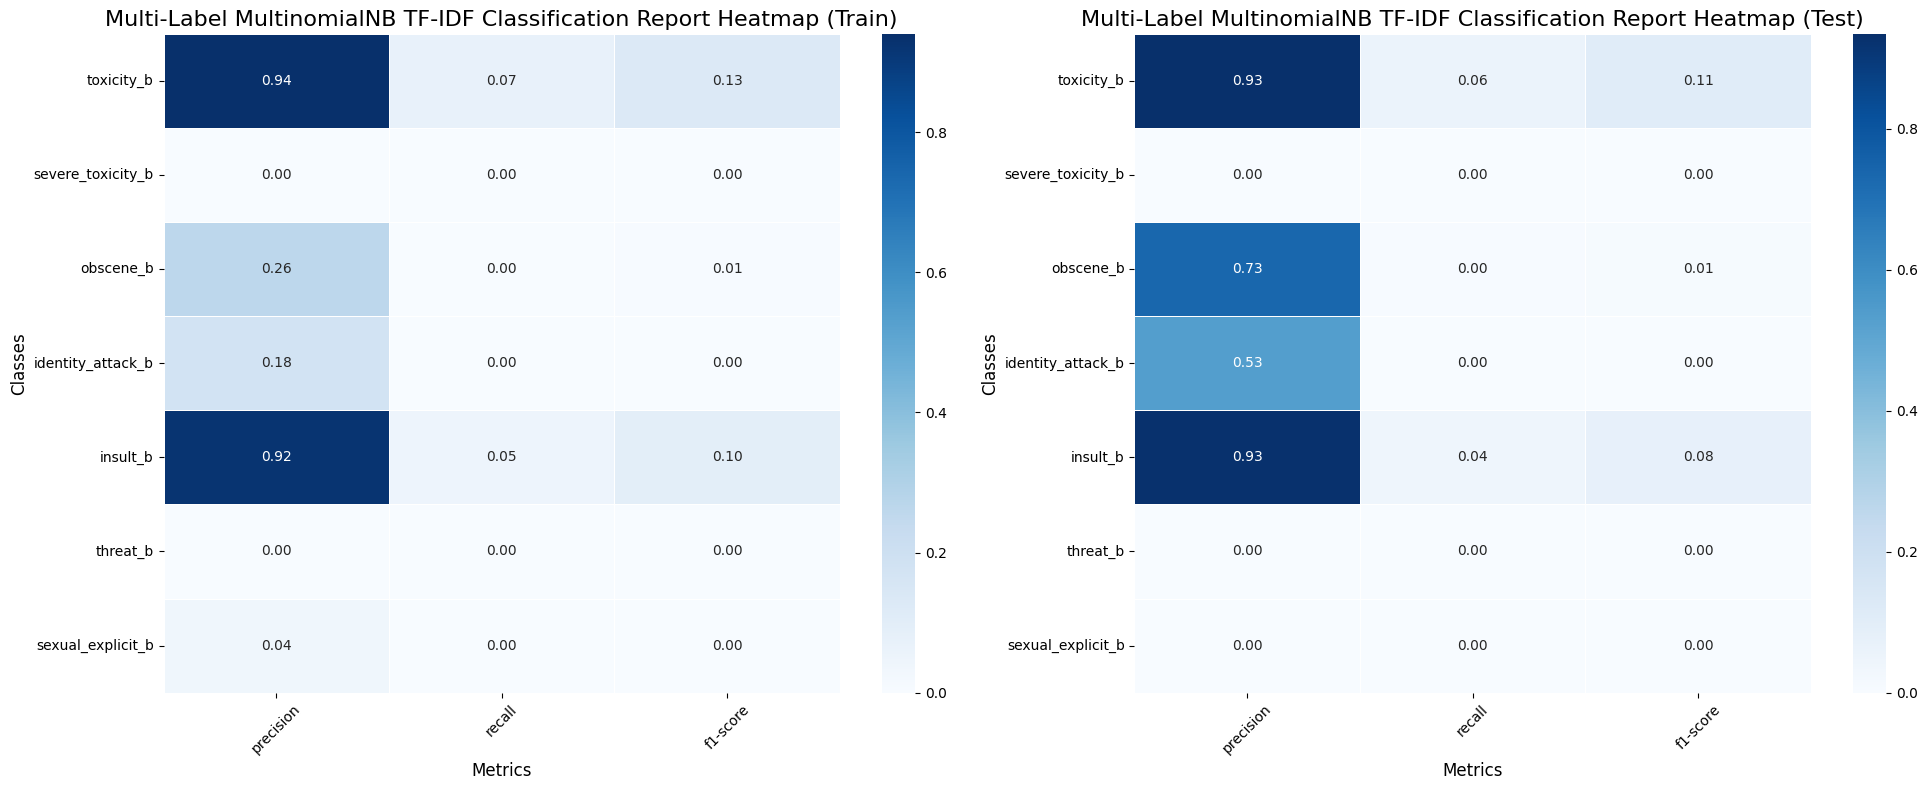

In [44]:
show_classification_report(
    y_train,
    y_test,
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_test,
    y.columns,
    'Multi-Label MultinomialNB TF-IDF'
)